# Build an LSTM-based Stock Price Predictor

1. Train an LSTM model for stock price forecasting.
2. Compare its performance with the basic RNN.
3. Visualize predictions over time.

We'll use real stock market data to train our LSTM model.

## Step 1 - Get the data

In [25]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

what is yf?

yfinance is a popular, open-source Python library that allows users to access and download financial data from Yahoo Finance. It's developed by Ran Aroussi and provides access to a wide range of data, including stock quotes, options, and fundamental financials

In [26]:
ticker = 'AAPL' # you can change this to 'GOOG' or any other stock ticker. Or a list of multiple tickers. 
# adding more tickers will have grave consequences

In [27]:
# Download AAPL stock data for the past 5 years
stock_data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

# Display first few rows
print(stock_data.head())


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2019-01-02  37.667187  37.889013  36.787045  36.944469  148158800
2019-01-03  33.915257  34.757234  33.869937  34.342207  365248800
2019-01-04  35.363071  35.432244  34.299271  34.473390  234428400
2019-01-07  35.284359  35.499030  34.800162  35.468021  219111200
2019-01-08  35.956989  36.212208  35.425089  35.673149  164101200


In [28]:
stock_data.shape

(1258, 5)

In [29]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1258 non-null   float64
 1   (High, AAPL)    1258 non-null   float64
 2   (Low, AAPL)     1258 non-null   float64
 3   (Open, AAPL)    1258 non-null   float64
 4   (Volume, AAPL)  1258 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 59.0 KB


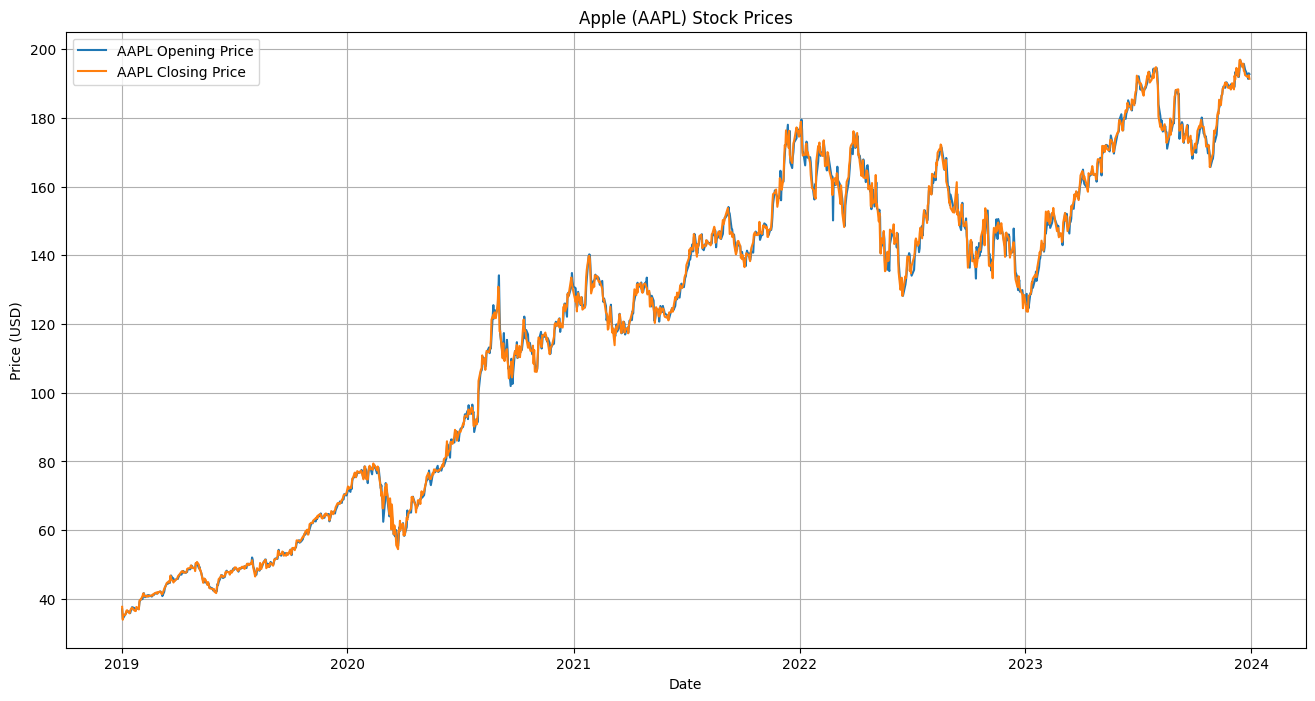

In [30]:
plt.figure(figsize=(16,8))
plt.plot(stock_data['Open'], label="AAPL Opening Price")
plt.plot(stock_data['Close'], label="AAPL Closing Price")
#plt.plot(stock_data['Volume'], label="AAPL Volume")
plt.title("Apple (AAPL) Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()


## Step 2: Data Preprocessing

We need to:
1. Extract 'Open', 'Close', 'Volume'
2. Calculate MA50 and MA100
3. Normalize Data – Scale values between 0 and 1 for better LSTM performance.
3. Create Sequences – Convert the data into time-series windows for LSTM.
4. Split into Training & Testing Sets – Use 80% for training, 20% for testing.



### Extract the said columns

We use the 'Open', 'Close', 'Volume' for multi-feature analysis.
The extracted data is stored in a NumPy array for easier manipulation.

In [31]:
df = stock_data[['Open', 'Close', 'Volume']].copy()

In [32]:
print(type(df), df.shape)

<class 'pandas.core.frame.DataFrame'> (1258, 3)


In [33]:
df.head()

Price,Open,Close,Volume
Ticker,AAPL,AAPL,AAPL
Date,,,
2019-01-02,36.944469,37.667187,148158800
2019-01-03,34.342207,33.915257,365248800
2019-01-04,34.473390,35.363071,234428400
2019-01-07,35.468021,35.284359,219111200
2019-01-08,35.673149,35.956989,164101200


### Calculate and add MA50 and MA100

Stock prices jump up and down daily. Moving averages "smooth" this data by averaging it over a window of time (e.g., 50 days), so you see the trend instead of short-term noise.

In [34]:
df["MA50"] = df['Close'].rolling(window=50).mean()
df["MA100"] = df['Close'].rolling(window=100).mean()

# This adds NaN for the first 49 (or 99) rows since there’s not enough data to compute those.
# We need to drop these rows.

df.dropna(inplace=True)

<Axes: xlabel='Date'>

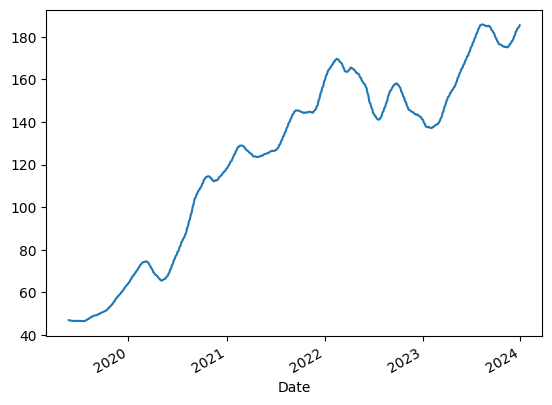

In [35]:
df["MA50"].plot()

<Axes: xlabel='Date'>

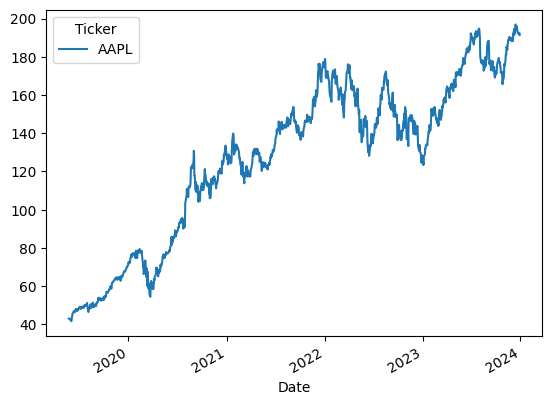

In [36]:
df["Close"].plot()

### Normalize Data – Scale values between 0 and 1 for better LSTM performance.

Stock prices have large variations (e.g., AAPL ranged from $30 to $180 over 5 years).
LSTMs work better when input values are scaled between 0 and 1 to improve training stability.
Min-Max Scaling helps prevent issues like exploding gradients and speeds up learning.

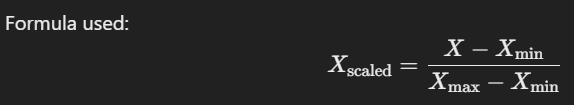

This transformation ensures that all values lie within the same range, making the model more stable.



In [37]:
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df)

In [38]:
df_scaled

array([[7.40124026e-03, 8.78193025e-03, 1.75943450e-01, 3.35251900e-03,
        0.00000000e+00],
       [5.41103700e-03, 7.63583721e-03, 2.18019503e-01, 3.10489675e-03,
        3.76588599e-04],
       [1.52373678e-03, 6.31927373e-03, 2.23316902e-01, 2.76262747e-03,
        1.01053306e-03],
       ...,
       [9.64455347e-01, 9.68243063e-01, 5.97309011e-02, 9.92441225e-01,
        9.96835150e-01],
       [9.75060748e-01, 9.70996143e-01, 2.48510604e-02, 9.94818131e-01,
        9.97931699e-01],
       [9.73518222e-01, 9.64273544e-01, 4.61671260e-02, 9.97231882e-01,
        9.98884208e-01]])

In [39]:
df_scaled.shape

(1159, 5)

In [40]:
print(df.columns)
feature_columns = [x[0] for x in df.columns]
print(feature_columns)

MultiIndex([(  'Open', 'AAPL'),
            ( 'Close', 'AAPL'),
            ('Volume', 'AAPL'),
            (  'MA50',     ''),
            ( 'MA100',     '')],
           names=['Price', 'Ticker'])
['Open', 'Close', 'Volume', 'MA50', 'MA100']


In [41]:
df_scaled = pd.DataFrame(df_scaled, columns=feature_columns, index=df.index)
df_scaled.head()

,Open,Close,Volume,MA50,MA100
Date,,,,,
2019-05-24,0.007401,0.008782,0.175943,0.003353,0.000000
2019-05-28,0.005411,0.007636,0.218020,0.003105,0.000377
2019-05-29,0.001524,0.006319,0.223317,0.002763,0.001011
2019-05-30,0.003903,0.007744,0.151133,0.002503,0.001555
2019-05-31,0.001228,0.002741,0.209029,0.002077,0.002050


In [42]:
print(df_scaled.columns)

Index(['Open', 'Close', 'Volume', 'MA50', 'MA100'], dtype='object')


In [45]:
target_column_index = df_scaled.columns.get_loc('Close')
print(target_column_index)

1


In [52]:
df_scaled.values[0,1]

np.float64(0.008781930251644865)

### Create Sequences – Convert the data into time-series windows for LSTM.

Unlike traditional ML models, LSTMs need sequential time-series input to learn patterns.
We convert raw stock prices into sequences where:

Input (X): Last 60 days of all features

Output (y): The next day's closing price

This helps the LSTM learn dependencies between past prices and future prices.
Example:

If X = [Day 1, Day 2, ..., Day 60]

Then y = [Day 61] (price we want to predict)

This step is critical because LSTMs specialize in learning patterns across sequences.

In [56]:
def create_sequences_multivariate(data, target_column_index, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, target_column_index])
    return np.array(X), np.array(y)

# Use 30/60 days of past data to predict the next day's price
time_steps = 30
target_column_index = df_scaled.columns.get_loc('Close') # get column number for the target
X, y = create_sequences_multivariate(df_scaled.values, target_column_index, time_steps)

# Reshape y to be 2D (optional but often helps with Keras)
y = y.reshape(-1, 1)

In [57]:
print("X shape:", X.shape)  # Expect (samples, 30, 5)
print("y shape:", y.shape)  # Expect (samples, 1)

X shape: (1129, 30, 5)
y shape: (1129, 1)


### Split into Training & Testing Sets – Use 80% for training, 20% for testing.

We split the data 80-20 to train and evaluate the model properly.
The first 80% is used for training, allowing the model to learn historical patterns.
The last 20% is for testing, ensuring the model can generalize to unseen data.
This ensures that our model is evaluated on future stock prices, simulating a real-world scenario.

In [58]:
split = int(len(X) * 0.8)  # 80% training, 20% testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# we don't shuffle the data, cause it is time-ordered (sequential) # duh!

In [59]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (903, 30, 5)
X_test: (226, 30, 5)
y_train: (903, 1)
y_test: (226, 1)


## Step 3: Build the LSTM Model

Model Architecture
* LSTM Layers – Capture patterns in sequential stock prices.
* Dropout Layer – Prevent overfitting.
* Dense Layer – Predict the next stock price.
* Adam Optimizer – Adjusts learning rate dynamically.

In [60]:
# Define LSTM Model
model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(units=100, return_sequences=True),  # First LSTM layer
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(units=50, return_sequences=False),  # Second LSTM layer
    Dense(units=1)  # Output layer (predicts next stock price)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,651 (283.79 KB)

 Trainable params: 72,651 (283.79 KB)

 Non-trainable params: 0 (0.00 B)

## Step 4: Train the model

In [65]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.8546e-04 - val_loss: 0.0016
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.9795e-04 - val_loss: 0.0012
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.6608e-04 - val_loss: 0.0011
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.0139e-04 - val_loss: 0.0018
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.9450e-04 - val_loss: 0.0013
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.7172e-04 - val_loss: 0.0010
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.3661e-04 - val_loss: 0.0011
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.9243e-04 - val_loss: 0.0011
Epoch 12/50
26/26 ━━━━━━━━━━━━━

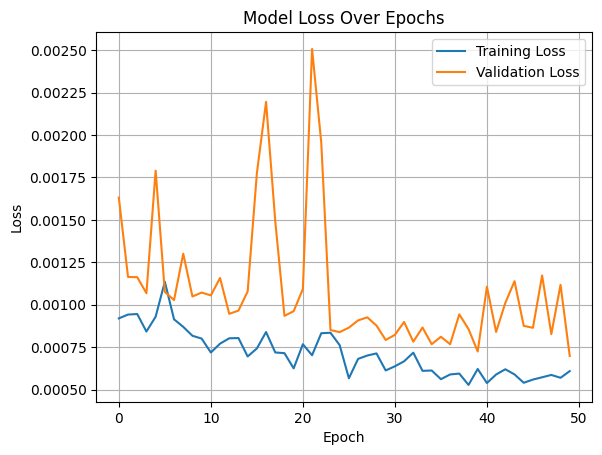

In [66]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Step 5: Make Predictions & Evaluate Performance

In [67]:
# Predict on test data
predicted = model.predict(X_test)

# Inverse transform the predictions and true values (only 'Close' column)
predicted_prices = scaler.inverse_transform(
    np.concatenate([np.zeros((predicted.shape[0], df.shape[1] - 1)), predicted], axis=1)
)[:, -1]

actual_prices = scaler.inverse_transform(
    np.concatenate([np.zeros((y_test.shape[0], df.shape[1] - 1)), y_test], axis=1)
)[:, -1]


# scaler.inverse_transform(...) expects an array with the same number of features as the original scaled data (5 features in our case — Open, Close, Volume, MA50, MA100). 
# But predicted and y_test only contain the Close price (i.e., shape (samples, 1)).
# We "padded" dummy zeros for the other 4 features, and placed the predicted values where the Close column was — the last column in our original dataset.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


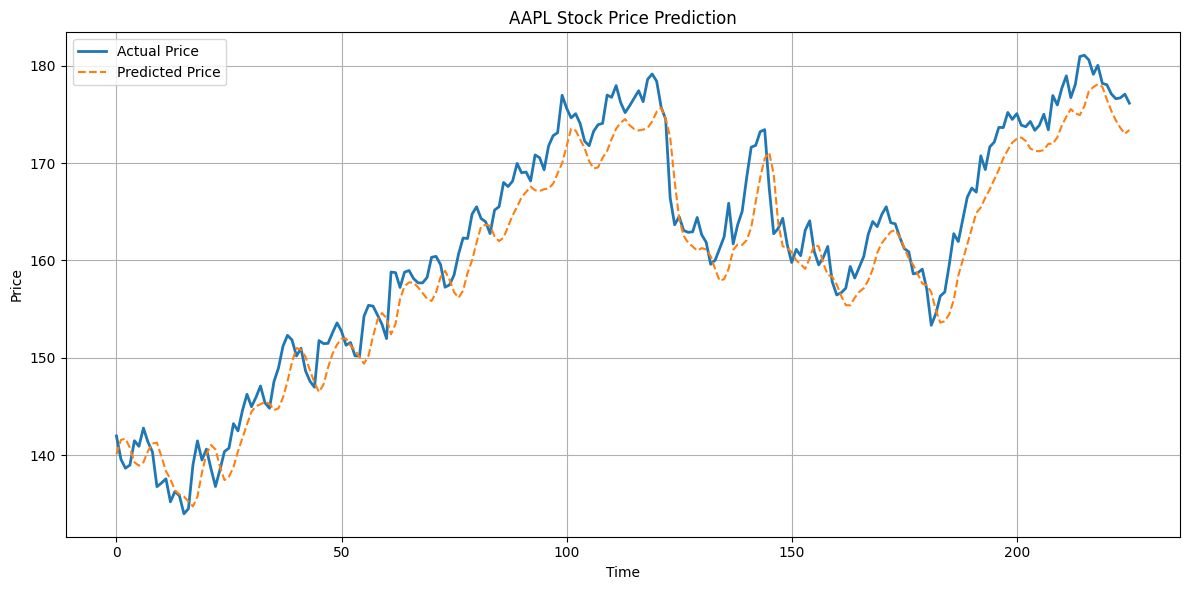

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Price", linewidth=2)
plt.plot(predicted_prices, label="Predicted Price", linestyle="--")
plt.title("AAPL Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
